# Delta Function Appeal

This notebook presents an agent-based model that simulates the propagation of a disease through a network.
It demonstrates how to use the [agentpy](https://agentpy.readthedocs.io) package to create and visualize networks, use the interactive module, and perform different types of sensitivity analysis. 

In [4]:
# Model design
import agentpy as ap
import networkx as nx 
import random 
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns
import IPython
import pickle
np.random.seed(42)

In [5]:
import os

if os.path.isdir("../notebooks"):
    os.chdir("..")

from utils import viz, delta_function, transform_pd

from agent import Person

from model import VirusModel, VirusModel_baseline


## About the model

The agents of this model are people, which can be in one of the following three conditions: susceptible to the disease (S), infected (I), or recovered (R). The agents are connected to each other through a small-world network of peers. At every time-step, infected agents can infect their peers or recover from the disease based on random chance.

## Running a simulation

To run our model, we define a dictionary with our parameters. 
We then create a new instance of our model, passing the parameters as an argument, 
and use the method :func:`Model.run` to perform the simulation and return it's output. 

In [24]:
parameters = {
    'my_parameter':42,
    'agents':200,
    'steps':100,
    'wealth_appeal_corr': 0, # >0 more wealth higher appeal chance
    'acc': 0.8, # accuracy of fraud prdediction
    'appeal_wealth': 0.3, # minimal wealth needed for appeal (could also become a param for distr. eventually)
    #'wealth_impact'
    'clf': 'pretrained', # None, 'hist'
    'expi': None,
    'fraud_det': 0,
    'fairness_metrics' : False
    
}

sample = ap.Sample(parameters, n=1)
# model_baseline = VirusModel_baseline(parameters)
exp = ap.Experiment(VirusModel_baseline, sample, iterations =1, record = True)
results_baseline = exp.run() 


Scheduled runs: 1
using predtrined clf


KeyboardInterrupt: 

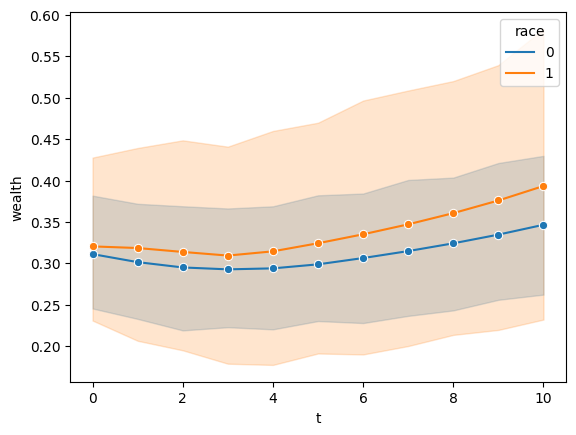

In [7]:
    
df_baseline = results_baseline['variables']['Person']

viz(df_baseline, df_baseline.index.get_level_values('t'), df_baseline['wealth'].astype(float), df_baseline['race'])

In [ ]:
# # plot wealth against fraud and fraud prediction
# df_baseline['fraud_pred']
# df_baseline.index.get_level_values('t')
# a = df_baseline.loc[:,['wealth','fraud_pred']]
# # sns.violinplot(a, x = 'wealth', y = 'fraud_pred')
# df_baseline.columns = df_baseline.columns.map(''.join)
# print(df_baseline.index.names)
# df_baseline.xs('t', level=0, axis=0, drop_level=True)
# # viz(df_baseline, df_baseline.index.get_level_values('t'), df_baseline['wealth'].astype(float), df_baseline['fraud_pred'])

In [25]:
parameters_b = {
    'my_parameter':42,
    'agents':200,
    'steps':100,
    'wealth_appeal_corr': 0, # >0 more wealth higher appeal chance
    'acc': 0.8, # accuracy of fraud prdediction
    'appeal_wealth': 0.3, # minimal wealth needed for appeal (could also become a param for distr. eventually)
    #'wealth_impact'
    'clf': 'pretrained', # None, 'hist'
    'expi': 'appeal',
    'fraud_det': 0,
    'fairness_metrics' : False
    
    
}


sample_b = ap.Sample(parameters_b, n=1)
model_b = VirusModel(parameters_b)
exp = ap.Experiment(VirusModel, sample, iterations =1, record = True)
results_baseline = exp.run() 


Scheduled runs: 1


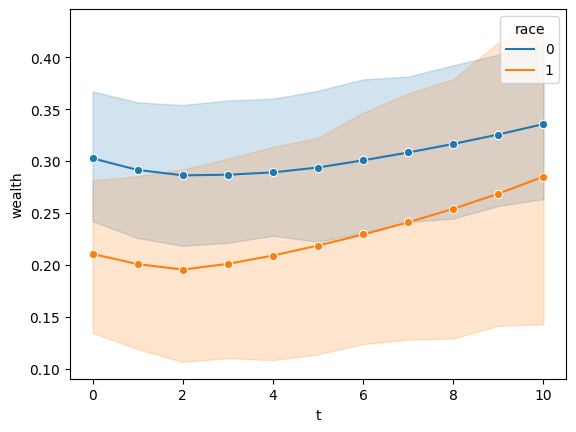

In [9]:

df = results_baseline['variables']['Person']

viz(df, df.index.get_level_values('t'), df['wealth'].astype(float), df['race'])

In [ ]:
# create baseline value
df_b1 = df_baseline.iloc[(df_baseline['race'] == 1).values] 
baseline1 = df_b1.groupby(level='t').mean()
# df_b
df_b0 = df_baseline.iloc[(df_baseline['race'] == 0).values] 
baseline0 = df_b0.groupby(level='t').mean()

In [ ]:
df_x1 = df.iloc[(df['race'] == 1).values] 
df_wb1 = df_x1['wealth'] - baseline1['wealth']
df_x1['wealth'] = df_wb1




df_x0 = df.iloc[(df['race'] == 0).values] 
df_wb0 = df_x0['wealth'] - baseline0['wealth']
df_x0['wealth'] = df_wb0

df_xb = pd.concat([df_x0, df_x1])


/var/folders/_3/m4zxq5yx589d0965c6l5j1q80000gp/T/ipykernel_15756/2096043862.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x1['wealth'] = df_wb1
/var/folders/_3/m4zxq5yx589d0965c6l5j1q80000gp/T/ipykernel_15756/2096043862.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x0['wealth'] = df_wb0


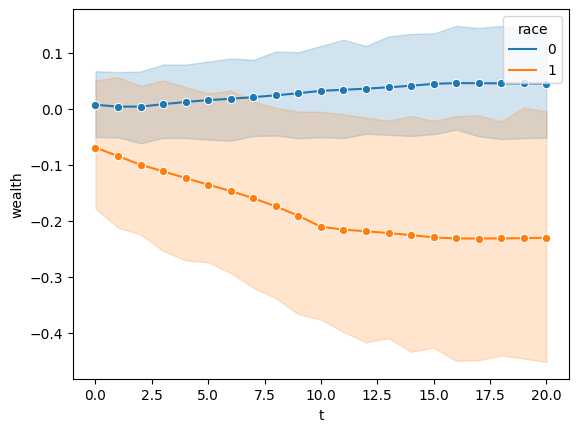

In [ ]:
viz(df_xb, df_xb.index.get_level_values('t'), df_xb['wealth'].astype(float), df_xb['race'])

## Delta Function 

In [ ]:
# run baseline and normal model and save results

exp = ap.Experiment(VirusModel_baseline, parameters, iterations =5, record=True)
results_baseline = exp.run() 

df_baseline = results_baseline['variables']['Person']

exp = ap.Experiment(VirusModel, parameters_b, iterations =5, record=True)
results = exp.run() 

df = results['variables']['Person']


Scheduled runs: 5
using predtrined clf


In [10]:
df = transform_pd(df)
df_baseline = transform_pd(df_baseline)


/Users/uni/Documents/Git/abm/basic/utils.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_baseline['intersect'] = list(df_baseline['gender'])
/Users/uni/Documents/Git/abm/basic/utils.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_baseline['intersect'] = list(df_baseline['gender'])


wealth   health  fraud_pred  fraud  race  gender  convicted  \
obj_id t                                                                   
1      1   0.539119  0.37454           0      1     1       0          0   
       2   0.568184  0.37454           0      1     1       0          0   
       3   0.600467  0.37454           0      0     1       0          0   
       4   0.636523  0.37454           0      0     1       0          0   
       5   0.677040  0.37454           0      0     1       0          0   
...             ...      ...         ...    ...   ...     ...        ...   
100    6   0.000000  0.37454           1      1     1       0          1   
       7   0.000000  0.37454           1      1     1       0          1   
       8   0.000000  0.37454           1      1     1       0          1   
       9   0.000000  0.37454           1      0     1       0          1   
       10  0.000000  0.37454           1      1     1       0          1   

           eod_gender  eod_race  dpd_gender  dpd_race  misclassifications  \
obj_id t                                                                    
1      1     0.282353  0.521739    0.282353  0.521739                   1   
       2     0.164773  0.727273    0.164773  0.727273                   1   
       3     0.255682  0.625000    0.255682  0.625000                   0   
       4     0.080000  0.606061    0.080000  0.606061                   0   
       5     0.401235  0.634058    0.401235  0.634058                   0   
...               ...       ...         ...       ...                 ...   
100    6     0.306878  0.652778    0.306878  0.652778                   0   
       7     0.332143  0.511111    0.332143  0.511111                   0   
       8     0.392157  0.601307    0.392157  0.601307                   0   
       9     0.193548  0.428571    0.193548  0.428571                   1   
       10    0.405594  0.652174    0.405594  0.652174                   0   

          intersect  
obj_id t             
1      1        fnw  
       2        fnw  
       3        fnw  
       4        fnw  
       5        fnw  
...             ...  
100    6        fnw  
       7        fnw  
       8        fnw  
       9        fnw  
       10       fnw  

[1000 rows x 13 columns]

/Users/uni/Documents/Git/abm/basic/utils.py:72: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_wb1 = df.iloc[(df[disc_axis] == i).values][y_axis] - df_b1.groupby(level='t').mean()[y_axis]
/Users/uni/Documents/Git/abm/basic/utils.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x1[y_axis] = df_wb1
/Users/uni/Documents/Git/abm/basic/utils.py:72: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which shoul

             wealth   health  fraud_pred  fraud  race  gender  convicted  \
obj_id t                                                                   
4      1   0.032543  0.37454           0      1     1       0          0   
       2   0.055604  0.37454           0      1     1       0          0   
       3   0.078287  0.37454           0      0     1       0          0   
       4   0.082780  0.37454           0      1     1       0          0   
       5   0.078888  0.37454           0      0     1       0          0   
...             ...      ...         ...    ...   ...     ...        ...   
98     6  -0.003900  0.37454           0      0     0       1          0   
       7   0.005604  0.37454           0      0     0       1          0   
       8   0.015744  0.37454           0      0     0       1          0   
       9   0.026554  0.37454           0      0     0       1          0   
       10  0.038134  0.37454           0      0     0       1          0   

           

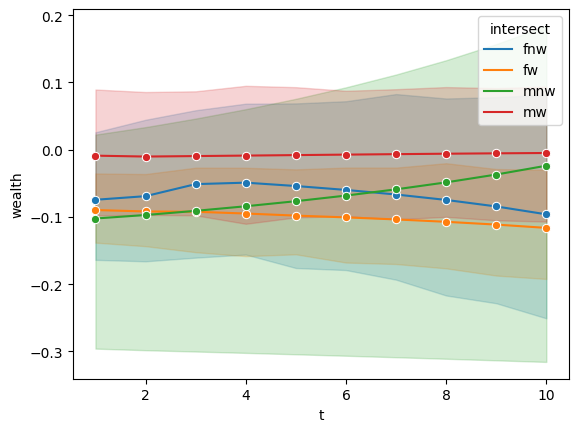

In [23]:
df_xb = delta_function('intersect', 'wealth', df, df_baseline)
print(df_xb)
viz(df_xb, df_xb.index.get_level_values('t'), df_xb['wealth'].astype(float), df_xb['intersect'])

Do I want this or do I want just one line that indicates if r0 or r1 profits more? This


In [ ]:
# def delta_function(disc_axis, y_axis, df, df_baseline):
#     """ Delta function visualizes absolute difference between baseline scenario and more complex scenario """

#     df_b1 = df_baseline.iloc[(df_baseline[disc_axis] == 1).values] 
#     df_wb1 = df.iloc[(df[disc_axis] == 1).values][y_axis] - df_b1.groupby(level='t').mean()[y_axis]
#     df_x1 = df.iloc[(df[disc_axis] == 1).values]
#     df_x1[y_axis] = df_wb1
    
#     df_b0 = df_baseline.iloc[(df_baseline[disc_axis] == 0).values] 
#     df_wb0 = df.iloc[(df[disc_axis] == 0).values] [y_axis] - df_b0.groupby(level='t').mean()[y_axis]
#     df_x0 = df.iloc[(df[disc_axis] == 0).values]
#     df_x0[y_axis] = df_wb0
    
#     return pd.concat([df_x0, df_x1])

In [ ]:
# create baseline value fraud prediction medium income

df_b1 = df_baseline.iloc[(df_baseline['fraud_pred'] == 1).values] 
baseline1 = df_b1.groupby(level='t').mean()
# df_b
df_b0 = df_baseline.iloc[(df_baseline['fraud_pred'] == 0).values] 
baseline0 = df_b0.groupby(level='t').mean()

baseline0
df_b0

# df_x1 = df.iloc[(df_baseline['fraud_pred'] == 1).values] 
# df_wb1 = df_x1['wealth'] - baseline1['wealth']
# df_x1['wealth'] = df_wb1




df_x0 = df_baseline.iloc[(df_baseline['fraud_pred'] == 0).values] 
df_wb0 = df_x0['wealth'] - baseline0['wealth']
df_x0['wealth'] = df_wb0

df_xb = pd.concat([df_x0, df_x1])

df_xb

/var/folders/_3/m4zxq5yx589d0965c6l5j1q80000gp/T/ipykernel_73611/296530877.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x0['wealth'] = df_wb0


wealth  fraud_pred  fraud  race  gender  convicted
iteration obj_id t                                                        
0         1      1   -0.097182           0      0     0       1          0
                 2   -0.098531           0      0     0       1          0
                 3   -0.098119           0      0     0       1          0
                 4   -0.097747           0      1     0       1          0
                 5   -0.098071           0      0     0       1          0
...                        ...         ...    ...   ...     ...        ...
4         498    96  -0.460377           1      0     1       1          1
                 97  -0.459618           1      1     1       1          1
                 98  -0.460181           1      1     1       1          1
                 99  -0.459802           1      1     1       1          1
                 100 -0.460165           1      1     1       1          1

[608572 rows x 6 columns]